In [ ]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [ ]:
from scripts.convert_brat_annotations_to_json import *
import seaborn as sns
import matplotlib.pyplot as plt
from baseline.baseline import *
from scripts.analyse_pwc_entity_results import *

In [ ]:
df_concat = combine_brat_to_original_data('../data/pwc_s2_cleaned_text_v2.jsonl',
                                          '../data/pwc_s2_cleaned_text_v2_sentences.jsonl',
                                          '../outputs/pwc_s2_cleaned_text_v2_sentences_predictions.jsonl',
                                          '/home/sarthakj/brat/brat/data/result_extraction/outputs/brat_annotation_folder_doclevel_original/',
                                          '/home/sarthakj/brat/brat/data/result_extraction/outputs/brat_annotation_folder_doclevel/')

In [ ]:
df_norm = read_dataframe(df_concat)
dump_to_file(df_norm, '../model_data/pwc_split_on_sectioned', max_id='0e37c8f19eefeb0c20d92f5cb4df4153077c116b')

In [ ]:
from runtime_scripts.read_all_files import get_all_file_outputs

In [ ]:
data = get_all_file_outputs('../outputs/unannotated_results_folder/')

In [ ]:
data = pd.DataFrame(data.values())

In [ ]:
(data['words'].apply(len) > 10000).sum()

In [ ]:
from dygie.data.dataset_readers.read_pwc_dataset import *
# dump_to_file(read_dataframe(df_concat))

In [ ]:
from scripts.convert_pwc_to_brat import *

In [ ]:
generate_brat_annotations('../data/pwc_s2_cleaned_text_v2.jsonl',
                          '../data/pwc_s2_cleaned_text_v2_sentences.jsonl',
                          '../outputs/pwc_s2_cleaned_text_v2_sentences_predictions.jsonl.clean',
                          '../brat/data/result_extraction/outputs/second_phase_annotations_test/')

In [ ]:
import json

In [ ]:
data = [json.loads(line) for line in open('../model_data/pwc_split_on_sectioned/train.jsonl')]

In [ ]:
nr = 0
nrt = 0
for line in data :
    n_ary_relations_all = [Relation(*x)._asdict() for x in line["n_ary_relations"]]
    corefs = {k: v for k, v in line['coref'].items() if len(v) > 0}
    n_ary_relations = [
        r for r in n_ary_relations_all if all([v in corefs for k, v in r.items() if k in used_entities])
    ]
    nr += len(n_ary_relations)
    nrt += len(n_ary_relations_all)
    
nr, nrt

In [ ]:
import os
os.chdir('../')

In [ ]:
import json

In [ ]:
from dygie.data.dataset_readers.pwc_json import PwCTagJsonReader
from allennlp.data.token_indexers import PretrainedBertIndexer

In [ ]:
instances = list(PwCTagJsonReader({"bert" : PretrainedBertIndexer('bert-base-uncased')})._read('model_data/dataset_readers_paths/train.json:pwc'))

In [ ]:
dev_instances = list(PwCTagJsonReader({"bert" : PretrainedBertIndexer('bert-base-uncased')})._read('model_data/dataset_readers_paths/dev.json:pwc'))

In [ ]:
from dygie.data.iterators.batch_iterator import BatchIterator

In [ ]:
batched_instances = BatchIterator._shuffle_documents(instances, shuffle=False)
dev_batched_instances = BatchIterator._shuffle_documents(dev_instances, shuffle=False)

In [ ]:
def extract_span_features(instance) :
    length = instance.fields['metadata'].metadata['document_metadata']['doc_length']
    start_ix = instance.fields['metadata'].metadata['start_pos_in_doc']
    spans_position = [(x.span_start, x.span_end) for x in instance.fields['spans'].field_list]
    entity_labels = instance.fields['span_entity_labels'].labels
    span_features = [x.labels for x in instance.fields['span_features'].field_list]
    fdicts = []
    
    y = instance.fields['span_link_labels'].labels
    new_y = []
    for pos, elabel, f, l in zip(spans_position, entity_labels, span_features, y) :
        if pos[0] > -1 :
            fdict = {'Position' : (2*start_ix + pos[0] + pos[1] + 1)/(2*length), 'Entity_label' : elabel}
            fdict.update({k:1 for k in f})
            fdicts.append(fdict)
            new_y.append(l)
    
    return fdicts, new_y

In [ ]:
fdists, ys = [], []
for ins in instances :
    fdist, y = extract_span_features(ins)
    fdists += fdist
    ys += y
    
dev_fdists, dev_ys = [], []
for ins in dev_instances :
    dev_fdist, dev_y = extract_span_features(ins)
    dev_fdists += dev_fdist
    dev_ys += dev_y
    
from sklearn.feature_extraction.dict_vectorizer import DictVectorizer
vec = DictVectorizer()
vec.fit(fdists)
fdists_vec = vec.transform(fdists)
dev_fdists_vec = vec.transform(dev_fdists)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', class_weight='balanced')
lr.fit(fdists_vec, ys)

from dygie.training.thresholding_f1_metric import BinaryThresholdF1
metrics = BinaryThresholdF1()
metrics(lr.predict_proba(dev_fdists_vec)[:, 1], np.array(dev_ys))
metrics.get_metric(False)

In [ ]:
import numpy as np

In [ ]:
coref_labels = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_labels'].reshape(-1) for x in batched_instances])
coref_mask = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_mask'].reshape(-1) for x in batched_instances])
coref_features = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_features'].reshape(-1, 13) for x in batched_instances])
coref_labels = coref_labels[coref_mask.astype(bool)]
coref_features = coref_features[coref_mask.astype(bool)]

In [ ]:
dev_coref_labels = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_labels'].reshape(-1) for x in dev_batched_instances])
dev_coref_mask = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_mask'].reshape(-1) for x in dev_batched_instances])
dev_coref_features = np.concatenate([x[0].fields['metadata'].metadata['document_metadata']['coref_features'].reshape(-1, 13) for x in dev_batched_instances])
dev_coref_labels = dev_coref_labels[dev_coref_mask.astype(bool)]
dev_coref_features = dev_coref_features[dev_coref_mask.astype(bool)]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(coref_features, coref_labels)

In [ ]:
from dygie.training.thresholding_f1_metric import BinaryThresholdF1

In [ ]:
metrics = BinaryThresholdF1()
metrics(lr.predict_proba(dev_coref_features)[:, 1], dev_coref_labels.astype(int))
metrics.get_metric(False)

In [ ]:
from dygie.data.dataset_readers.entity_linking_reader import PwCLinkerReader

In [ ]:
def print_span_corefs(instance) :
    text = instance.fields['text'].tokens
    spans = [(x.span_start, x.span_end+1) for x in instance.fields['spans'].field_list]
    labels = [x.labels for x in instance.fields['span_coref_labels'].field_list]
    entity_labels = instance.fields['span_entity_labels'].labels
    map_coref_labels = {k:v for v, k in instance.fields['metadata'].metadata['map_coref_keys'].items()}
    for span, label, el in zip(spans, labels, entity_labels) :
        print(span, text[span[0]:span[1]], [map_coref_labels[x] for x in label], el)

In [ ]:
from itertools import combinations

In [ ]:
def gen_pairs(instances) :
    e_label = [label for instance in instances if 'spans' in instance.fields for label in instance.fields['span_entity_labels'].labels]
    c_label = [label.labels for instance in instances if 'spans' in instance.fields for label in instance.fields['span_coref_labels'].field_list]
    text = [" ".join([x.text for x in ins.fields['text'].tokens[span.span_start:span.span_end + 1]]).lower() 
            for ins in instances if 'spans' in ins.fields for span in ins.fields['spans'].field_list]
    p, q = 0, 0
    for i, j in combinations(list(range(len(e_label))), 2) :
        if i == j : continue
        if e_label[i] != e_label[j] : continue
        if len(set(c_label[i]) & set(c_label[j])) > 0 or text[i] == text[j]: 
            p += 1
            q += 1
            continue
        if len(c_label[i]) == 0 and len(c_label[j]) == 0 : continue
        if len(set(c_label[i]) & set(c_label[j])) == 0 : q += 1
        
    return p, q

In [ ]:
sum([len(ins.fields['spans'].field_list) for ins in instances])

In [ ]:
x, y = zip(*[gen_pairs(x) for x in batched_instances])

In [ ]:
sum(x), sum(y)

In [ ]:
pairs = PwCLinkerReader.generate_pairs('model_data/pwc_split_on_sectioned/train.jsonl')
dev_pairs = PwCLinkerReader.generate_pairs('model_data/pwc_split_on_sectioned/dev.jsonl')

In [ ]:
train_features, train_labels = zip(*[(x[-1], 1 if x[2] == 'Entailment' else 0) for x in pairs])
dev_features, dev_labels = zip(*[(x[-1], 1 if x[2] == 'Entailment' else 0) for x in dev_pairs])
train_features, dev_features = np.array(train_features), np.array(dev_features)

In [ ]:
np.where(np.array(dev_features) != dev_coref_features)

In [ ]:
dev_features[0], dev_coref_features[0]

In [ ]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(train_features, train_labels)

metrics = BinaryThresholdF1()
metrics(lr.predict_proba(train_features)[:, 1], np.array(train_labels))
metrics.get_metric(False)

In [ ]:
dev_coref_labels = np.array([z
                            for x in dev_batched_instances 
                            for y in x[0].fields['metadata'].metadata['document_metadata']['coref_labels'] 
                            for z in y])

dev_coref_mask = np.array([z == 1
                            for x in dev_batched_instances 
                            for y in x[0].fields['metadata'].metadata['document_metadata']['coref_mask'] 
                            for z in y])

dev_coref_labels[dev_coref_mask]

In [ ]:
from collections import Counter
Counter([x[2] for x in pairs])

In [ ]:
sum([x[0].fields['metadata'].metadata['document_metadata']['coref_labels'].shape[0] for x in batched_instances])

In [ ]:
from dygie.data.dataset_readers.span_utils import span_pair_features

In [ ]:
span_pair_features((0, 2), (5, 6), "SQuAD Dataset", "squad1.1", {"words" : [0]*100})

In [ ]:
%run dygie/commands/predict_dygie.py outputs/pwc_outputs/experiment_dygie_crf_n_ary/testing_delete_2 outputs/pwc_outputs/experiment_linker/berty-bert-unfeatured/ model_data/dataset_readers_paths/dev.json:pwc outputs/n_ary_test 0

In [ ]:
import json
data = [json.loads(line) for line in open('../model_data/all_data_propagated.jsonl.jsonl')]

In [16]:
import json
data = [json.loads(line) for line in open('../outputs/test_outputs/clusters.jsonl')]

In [17]:
data[0].keys()

dict_keys(['doc_id', 'words', 'sections', 'sentences', 'ner', 'n_ary_relations', 'coref'])

In [7]:
p, g = list(zip(*[(len(x['prediction']), len(x['gold'])) for x in data]))

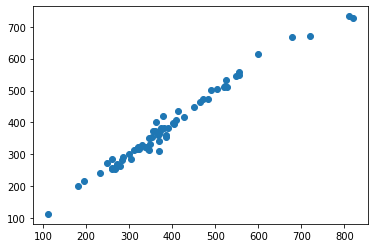

In [9]:
import matplotlib.pyplot as plt
plt.scatter(p, g)

In [12]:
import numpy as np
import pandas as pd
pd.Series(np.array(p) / np.array(g)).describe()

count    66.000000
mean      1.009840
std       0.053401
min       0.898148
25%       0.989241
50%       1.004005
75%       1.028345
max       1.193548
dtype: float64

In [15]:
np.sum(np.array(g)**2)

10936567

In [ ]:
from IPython.core.display import HTML, display
import re

def print_attn(sentence, attention, predicted) :
    l = []
    for i, (w, a, p) in enumerate(zip(sentence, attention, predicted)) :
        w = re.sub('&', '&amp;', w)
        w = re.sub('<', '&lt;', w)
        w = re.sub('>', '&gt;', w)
        c = 204
            
        add = ''
        
        v = "{:.2f}".format((1-a) * -0.5 + 0.5)
        l.append('<span style="background-color:hsl(' + str(c) + ',100%,' + str((1-a/2) * 50 + 50) + '%);' + add + '">' + w + '</span> ')
    
    display(HTML(''.join(l)))

In [ ]:
a = [0]*len(data[10]['words'])
for span in data[10]['entities'] :
    for i in range(span['token_start'], span['token_end']) :
        a[i] = 1

In [1]:
import re

In [33]:
def generate_token_and_indices(sentence):
    words = sorted(
        [(m.group(0), (m.start(), m.end())) for m in re.finditer(r"[^\s\+\-/]+", sentence)]
        + [(m.group(0), (m.start(), m.end())) for m in re.finditer(r"[\+\-/]+", sentence)]
        + [(m.group(0), (m.start(), m.end())) for m in re.finditer(r"\s+", sentence)],
        key=lambda x: x[1],
    )
    
    if len(words) == 0 :
        return [], []

    words, indices = list(zip(*[(t, i) for t, i in words if t.strip() != '']))

    return words, indices